In [1]:
import numpy as np

import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score

%matplotlib inline

# You can only call make_env() once, so don't lose it!
import riiideducation
#env = riiideducation.make_env()

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/riiid-test-answer-prediction/lectures.csv
/kaggle/input/riiid-test-answer-prediction/example_test.csv
/kaggle/input/riiid-test-answer-prediction/example_sample_submission.csv
/kaggle/input/riiid-test-answer-prediction/train.csv
/kaggle/input/riiid-test-answer-prediction/questions.csv
/kaggle/input/riiid-test-answer-prediction/riiideducation/__init__.py
/kaggle/input/riiid-test-answer-prediction/riiideducation/competition.cpython-37m-x86_64-linux-gnu.so


# INSPIRED BY

- [Kostiantyn Isaienkov's EDA Notebook](https://www.kaggle.com/isaienkov/riiid-answer-correctness-prediction-eda-modeling/)
- [Ilia Larchenko's Simple EDA and Baseline Notebook](https://www.kaggle.com/ilialar/simple-eda-and-baseline)


### Training data is in the competition dataset as usual

It's larger than will fit in memory with default settings, so we'll specify more efficient datatypes and only load a subset of the data for now.

In [2]:
#Reading Files

#train_df - Two options, for a smallish sample load data with code
# cell a couple below. For all data go to modelling section in notebook.

#questions.csv
used_data_types_dict = {
    'question_id': 'int16',
    'bundle_id': 'int16',
    'correct_answer': 'int8',
    'part': 'int8',
    'tags': 'str',
}


questions = pd.read_csv('/kaggle/input/riiid-test-answer-prediction/questions.csv',
                       usecols = used_data_types_dict.keys(), dtype=used_data_types_dict)


#lectures.csv
lect = pd.read_csv('../input/riiid-test-answer-prediction/lectures.csv')

#example_test
et = pd.read_csv('../input/riiid-test-answer-prediction/example_test.csv', index_col='row_id')

#train_df
train_df = pd.read_csv('/kaggle/input/riiid-test-answer-prediction/train.csv', low_memory=False, nrows=10**7, 
                       dtype={'row_id': 'int64',
                              'timestamp': 'int64',
                              'user_id': 'int32',
                              'content_id': 'int16',
                              'content_type_id': 'int8',
                              'task_container_id': 'int16',
                              'user_answer': 'int8',
                              'answered_correctly': 'int8',
                              'prior_question_elapsed_time': 'float32',
                              'prior_question_had_explanation': 'boolean',
                             })
print(train_df.shape)

(10000000, 10)


In [3]:
#CHECKLIST
#1: Explore variables
    #TRAIN.CSV 
    #QUESTIONS.CSV
    #LECTURES.CSV

#2: Explore creating new features from variables combinations



# Data Exploration Stuff

### train.csv

* timestamp: done
* user_id: done
* content_id: done
* content_type_id: done
* task_container_id: done
* user_answer: done
* answered_correctly: done
* prior_question_elapsed_time: done
* prior_question_had_explanation: done

In [4]:
train_df.isnull().sum()

row_id                                 0
timestamp                              0
user_id                                0
content_id                             0
content_type_id                        0
task_container_id                      0
user_answer                            0
answered_correctly                     0
prior_question_elapsed_time       234784
prior_question_had_explanation     39388
dtype: int64

In [5]:
correct = train_df[train_df['answered_correctly'] == 1]
incorrect = train_df[train_df['answered_correctly'] == 0]

print ("Correct: %i (%.1f%%)"%(len(correct), float(len(correct))/len(train_df)*100.0))
print ("Incorrect: %i (%.1f%%)"%(len(incorrect), float(len(incorrect))/len(train_df)*100.0))
print ("Total: %i"%len(train_df))

Correct: 6457425 (64.6%)
Incorrect: 3347179 (33.5%)
Total: 10000000


### timestamp

In [6]:
train_df.timestamp.describe()

count    1.000000e+07
mean     7.546528e+09
std      1.141381e+10
min      0.000000e+00
25%      5.109600e+08
50%      2.612310e+09
75%      9.751909e+09
max      8.470816e+10
Name: timestamp, dtype: float64

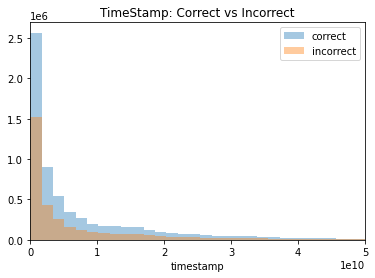

In [7]:
plt.xlim(0,50000000000)
sns.distplot(a=correct['timestamp'], label='correct', kde=False)
sns.distplot(a=incorrect['timestamp'], label="incorrect", kde=False)
plt.title("TimeStamp: Correct vs Incorrect")
plt.legend()

### prior_question_elapsed_time

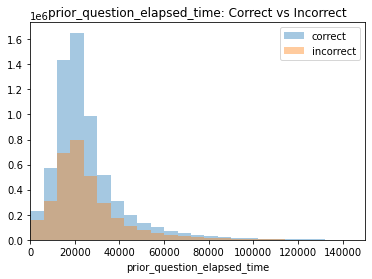

In [8]:
plt.xlim(0, 150000)

sns.distplot(a=correct['prior_question_elapsed_time'], label='correct', kde=False)
sns.distplot(a=incorrect['prior_question_elapsed_time'], label="incorrect", kde=False)
plt.title("prior_question_elapsed_time: Correct vs Incorrect")
plt.legend()

### prior_question_had_explanation

In [9]:
train_df[['prior_question_had_explanation', 'answered_correctly']].groupby(['prior_question_had_explanation'], 
                                                                           as_index=False, dropna=False).mean()

,prior_question_had_explanation,answered_correctly
0,False,0.235064
1,True,0.674771
2,<NA>,0.680309


Ideas?

* for the first question of a test is the prior_question_had_explanation always false, or is it filled with a null value?

* why are the prior_question_elapsed_time and prior_question_elapsed_time not the same in terms of null values?

### Task Container ID

In [10]:
train_df.task_container_id.nunique()


10000

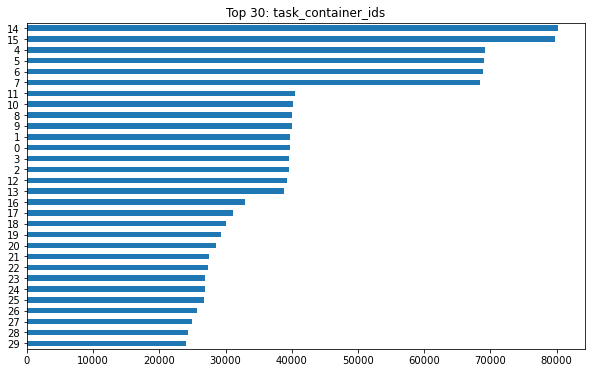

In [11]:
train_df['task_container_id'].value_counts(ascending=True)[-30:].plot(kind='barh', figsize=(10,6),
                                                                      title='Top 30: task_container_ids')

Text(0, 0.5, 'counts')

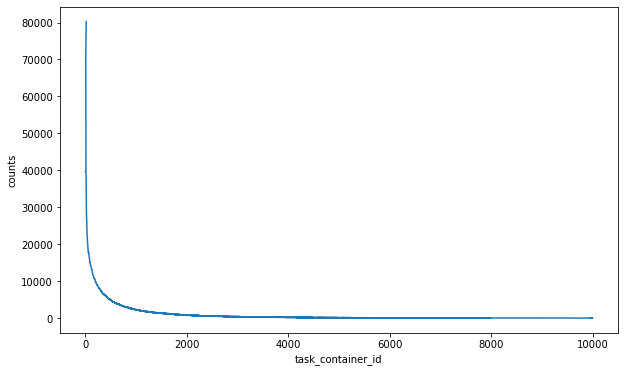

In [12]:
train_df['task_container_id'].value_counts().plot(kind='line', figsize=(10,6))
plt.xlabel('task_container_id')
plt.ylabel('counts')

### user_answer

In [13]:
train_df.user_answer.value_counts(normalize=True)

 0    0.278403
 1    0.266066
 3    0.257953
 2    0.178039
-1    0.019540
Name: user_answer, dtype: float64

In [14]:
train_df[['user_answer', 'answered_correctly']].groupby(['user_answer'], as_index=False).mean()

,user_answer,answered_correctly
0,-1,-1.000000
1,0,0.659294
2,1,0.649283
3,2,0.669495
4,3,0.659986


### User ID

In [15]:
train_df['user_id'].value_counts()

73289878     15871
39919444     14905
66756934     14510
195124785    14180
40224694     14136
             ...  
121434886        1
38532797         1
19887248         1
190075469        1
60215278         1
Name: user_id, Length: 39491, dtype: int64

In [16]:
#essentially makes a dataset with the value_counts of the user_id column
#need to figure out how to effectively use this.
ds = train_df['user_id'].value_counts().reset_index()
ds.columns = ['user_id', 'count']
ds = ds.sort_values('count')

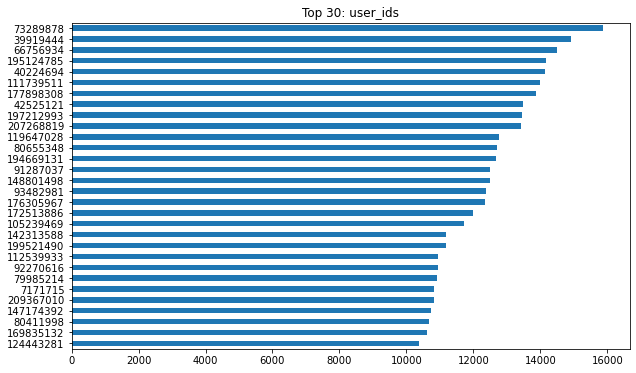

In [17]:
train_df['user_id'].value_counts(ascending=True)[-30:].plot(kind='barh', figsize=(10,6),
                                                                      title='Top 30: user_ids')

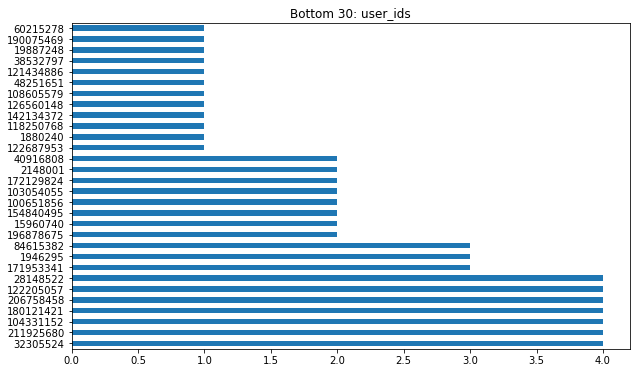

In [18]:
train_df['user_id'].value_counts()[-30:].plot(kind='barh', figsize=(10,6),
                                                                      title='Bottom 30: user_ids')

Text(0.5, 1.0, 'number of rows per user_id')

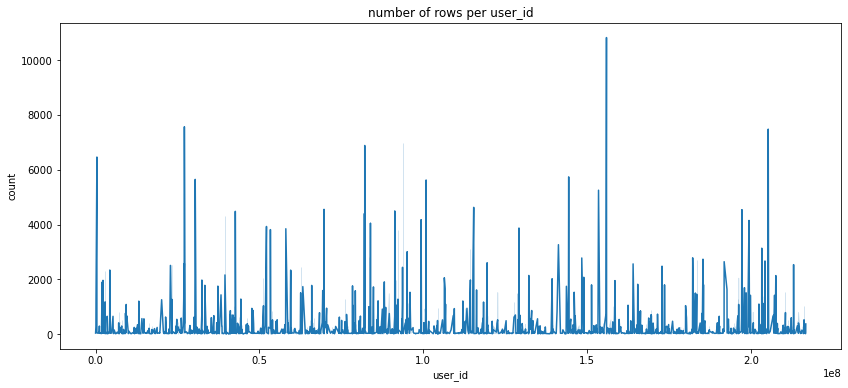

In [19]:
plt.figure(figsize=(14,6))
sns.lineplot(x=train_df['user_id'], y=train_df['user_id'].value_counts())
plt.xlabel("user_id")
plt.ylabel("count")
plt.title("number of rows per user_id")

we can see from the above that the value_count doesnt seem to change between low and high user_id's. 

### content_id

In [20]:
train_df.content_id.nunique()

13749

In [21]:
ds = train_df['content_id'].value_counts().reset_index()
ds.columns = ['content_id', 'count']
ds = ds.sort_values('count', ascending=False)

ds.head(5)

,content_id,count
0,6116,21103
1,6173,20060
2,4120,19826
3,175,19520
4,7876,18886


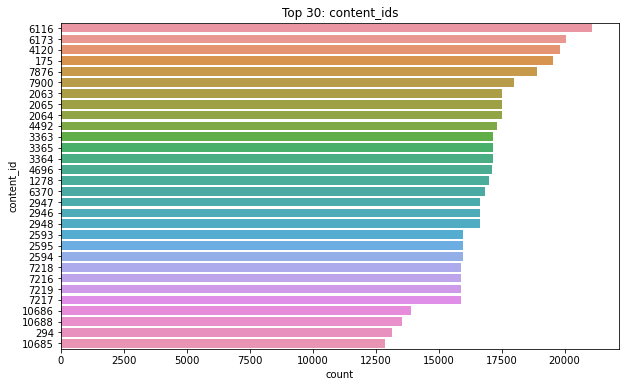

In [22]:
plt.figure(figsize=(10,6))
plt.title('Top 30: content_ids')

sns.barplot(x=ds.head(30)['count'], y=ds.head(30).content_id, orient = 'h', 
            order=ds.head(30).sort_values('count', ascending = False).content_id)

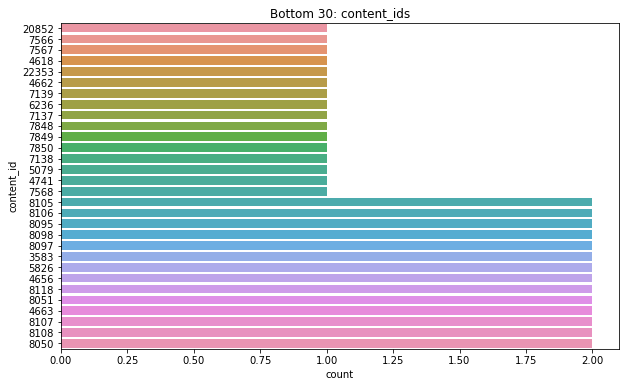

In [23]:
plt.figure(figsize=(10,6))
plt.title('Bottom 30: content_ids')

sns.barplot(x=ds.tail(30)['count'], y=ds.tail(30).content_id, orient = 'h', 
            order=ds.tail(30).sort_values('count').content_id)

Text(0, 0.5, 'count')

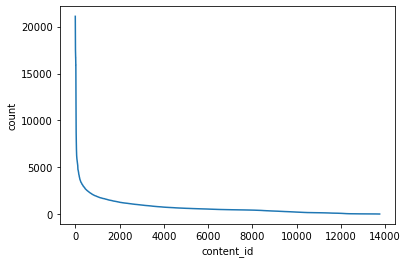

In [24]:
sns.lineplot(data=ds['count'])
plt.xlabel('content_id')
plt.ylabel('count')

### content_type_id

In [25]:
train_df.user_answer.value_counts()

 0    2784028
 1    2660660
 3    2579528
 2    1780388
-1     195396
Name: user_answer, dtype: int64

In [26]:
train_df.content_type_id.value_counts()

0    9804604
1     195396
Name: content_type_id, dtype: int64

* 0 if the event was a question being posed to the user
* 1 if the event was the user watching a lecture

note: we can see that there are the same number of content_type_id = 1 as there is user_answer = -1.

# questions.csv

question_id - foreign key for the content_id column in train/test data

In [27]:
que = pd.read_csv('/kaggle/input/riiid-test-answer-prediction/questions.csv', index_col='question_id')
que

,bundle_id,correct_answer,part,tags
question_id,,,,
0,0,0,1,51 131 162 38
1,1,1,1,131 36 81
2,2,0,1,131 101 162 92
3,3,0,1,131 149 162 29
4,4,3,1,131 5 162 38
...,...,...,...,...
13518,13518,3,5,14
13519,13519,3,5,8
13520,13520,2,5,73


In [28]:
que.isnull().sum()

bundle_id         0
correct_answer    0
part              0
tags              1
dtype: int64

### correct_answer

In [29]:
ds = que['correct_answer'].value_counts(normalize=True).reset_index()
ds.columns = ['correct_answer', 'number_of_answers']
ds = ds.sort_values(['number_of_answers'], ascending=False)

ds

,correct_answer,number_of_answers
0,0,0.274791
1,3,0.262072
2,1,0.257191
3,2,0.205945


### bundle_id

In [30]:
que.bundle_id.value_counts()

7795    5
6971    5
7421    5
7770    5
8144    5
       ..
8385    1
197     1
6342    1
4295    1
0       1
Name: bundle_id, Length: 9765, dtype: int64

In [31]:
ds = que.bundle_id.value_counts().value_counts(normalize=True)
ds = pd.DataFrame({'#_in_bundle':ds.index, 'percentage_of_questions':ds.values}) #created a data frame otherwise it would come out as a series
ds

,#_in_bundle,percentage_of_questions
0,1,0.834716
1,3,0.107834
2,4,0.038812
3,5,0.011367
4,2,0.007271


In [32]:
que.loc[que['bundle_id'] == 7795]

,bundle_id,correct_answer,part,tags
question_id,,,,
7795,7795,1,7,145 160 16 22 122
7796,7795,2,7,118 160 16 22 122
7797,7795,1,7,97 160 16 22 122
7798,7795,2,7,97 160 16 22 122
7799,7795,1,7,97 160 16 22 122


Note: Maybe bundles with more that one question are connected? ie if you get the first question wrong you might be able to solve the remaining Q's?


### part

In [33]:
ds = que['part'].value_counts(normalize=True).reset_index()
ds.columns = ['parts', 'percentage_of_questions']
ds = ds.sort_values(['percentage_of_questions'], ascending=False)
ds

,parts,percentage_of_questions
0,5,0.407528
1,2,0.121793
2,3,0.115507
3,4,0.106411
4,6,0.089625
5,7,0.085780
6,1,0.073357


### tags

some feature eng here for sure

In [34]:
#seeing how many tags most of the questions have 
ds = que['tags'].str.split().str.len().value_counts(normalize=True)
ds = pd.DataFrame({'#_of_tags':ds.index, 'percentage_of_questions':ds.values})
ds['#_of_tags'] = ds['#_of_tags'].astype(int)

ds

,#_of_tags,percentage_of_questions
0,1,0.485135
1,3,0.294039
2,4,0.149460
3,5,0.050732
4,2,0.012646
5,6,0.007987


In [35]:
#seeing which tags occur most frequently
ds = que['tags'].str.split(' ').explode('tags').reset_index()
ds = ds['tags'].value_counts().reset_index()
ds.columns = ['tag_number', 'count']

ds

,tag_number,count
0,92,2269
1,38,2256
2,81,1969
3,29,1707
4,136,1033
...,...,...
183,34,6
184,63,5
185,121,5
186,186,3


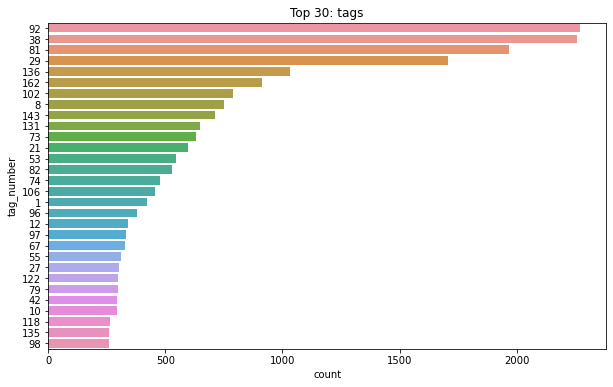

In [36]:
plt.figure(figsize=(10,6))
plt.title('Top 30: tags')

sns.barplot(x=ds.head(30)['count'], y=ds.head(30).tag_number, orient = 'h', 
            order=ds.head(30).sort_values('count', ascending = False).tag_number)

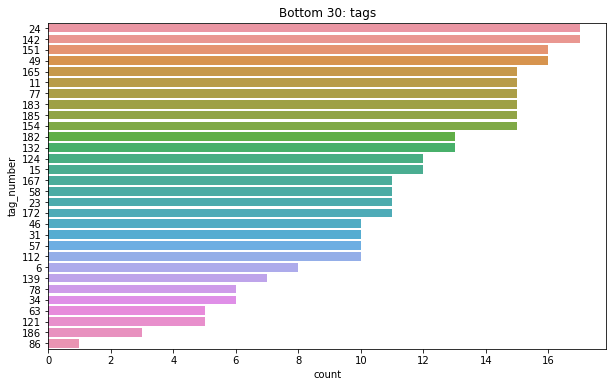

In [37]:
plt.figure(figsize=(10,6))
plt.title('Bottom 30: tags')

sns.barplot(x=ds.tail(30)['count'], y=ds.tail(30).tag_number, orient = 'h', 
            order=ds.tail(30).sort_values('count', ascending = False).tag_number)

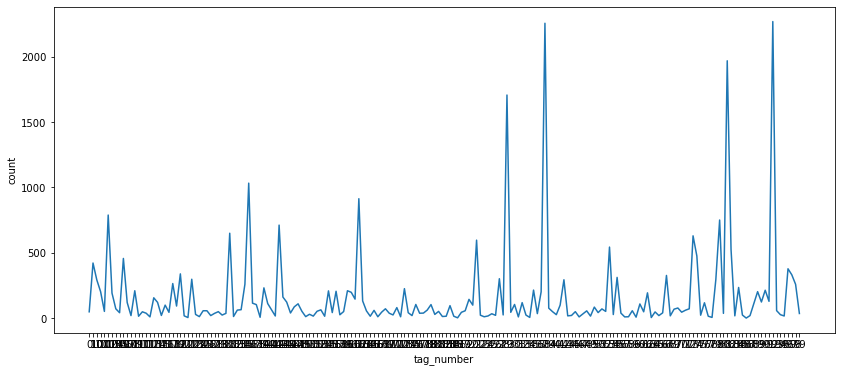

In [38]:
plt.figure(figsize=(14,6))
sns.lineplot(x=ds['tag_number'], y=ds['count'])

# lectures.csv

In [39]:
lect = pd.read_csv('../input/riiid-test-answer-prediction/lectures.csv')
lect

,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept
2,185,45,6,concept
3,192,79,5,solving question
4,317,156,5,solving question
...,...,...,...,...
413,32535,8,5,solving question
414,32570,113,3,solving question
415,32604,24,6,concept
416,32625,142,2,concept


In [40]:
lect.isnull().sum()

lecture_id    0
tag           0
part          0
type_of       0
dtype: int64

### Part

In [41]:
ds = lect.part.value_counts()
ds

5    143
6     83
2     56
1     54
7     32
4     31
3     19
Name: part, dtype: int64

In [42]:
ds = lect.part.value_counts(normalize=True)
ds = pd.DataFrame({'part_numb':ds.index, 'percentage_of_questions':ds.values})
ds

,part_numb,percentage_of_questions
0,5,0.342105
1,6,0.198565
2,2,0.133971
3,1,0.129187
4,7,0.076555
5,4,0.074163
6,3,0.045455


### type_of

In [43]:
ds = lect.type_of.value_counts()
ds

concept             222
solving question    186
intention             7
starter               3
Name: type_of, dtype: int64

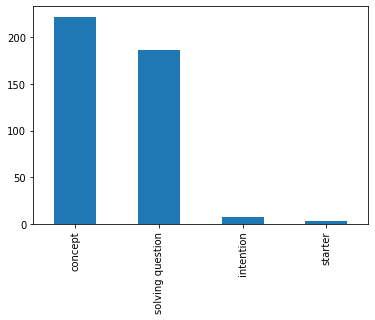

In [44]:
ds = lect.type_of.value_counts()
ds.plot(kind='bar', )

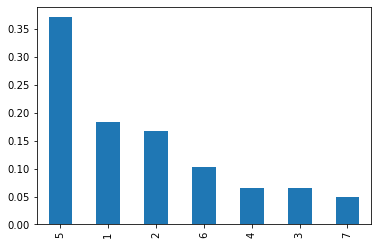

In [45]:
ds = lect.loc[lect['type_of'] == 'solving question']
ds.part.value_counts(normalize=True).plot(kind='bar')

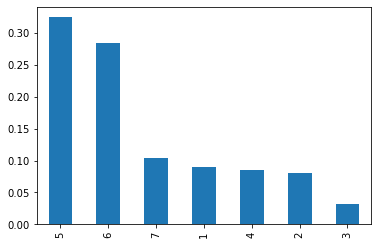

In [46]:
ds = lect.loc[lect['type_of'] == 'concept']
ds.part.value_counts(normalize=True).plot(kind='bar')

### Tag

Text(0.5, 1.0, 'Number of Lectures with each tag number')

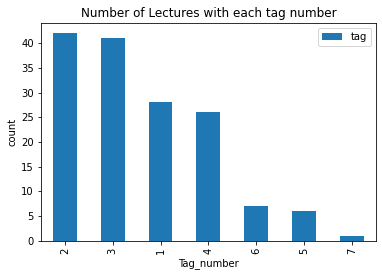

In [47]:
lect.tag.value_counts().value_counts().to_frame().plot(kind='bar')
plt.xlabel('Tag_number')
plt.ylabel('count')
plt.title('Number of Lectures with each tag number')

# example_test_rows.csv

In [48]:
et = pd.read_csv('../input/riiid-test-answer-prediction/example_test.csv', index_col='row_id')
et

,group_num,timestamp,user_id,content_id,content_type_id,task_container_id,prior_question_elapsed_time,prior_question_had_explanation,prior_group_answers_correct,prior_group_responses
row_id,,,,,,,,,,
0,0,0,275030867,5729,0,0,NaN,NaN,[],[]
1,0,13309898705,554169193,12010,0,4427,19000.0,True,NaN,NaN
2,0,4213672059,1720860329,457,0,240,17000.0,True,NaN,NaN
3,0,62798072960,288641214,13262,0,266,23000.0,True,NaN,NaN
4,0,10585422061,1728340777,6119,0,162,72400.0,True,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
104,3,13167339284,1900527744,3004,0,1179,24667.0,True,NaN,NaN
105,3,13167339284,1900527744,3003,0,1179,24667.0,True,NaN,NaN
106,3,64497673060,7792299,7908,0,676,19000.0,True,NaN,NaN


# Some Feature Engineering

In [49]:
train_questions_only_df = train_df[train_df['answered_correctly']!=-1]
train_questions_only_df.head(1)

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,0,1,3,1,NaN,<NA>


In [50]:
train_questions_only_df = pd.merge(train_questions_only_df, questions['part'], 
                                   left_on='content_id', right_index=True, how = 'left')
train_questions_only_df.head(1)

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,part
0,0,0,115,5692,0,1,3,1,NaN,<NA>,5


In [51]:
#removes rows that are lectures and .groupby the user_id
grouped_by_user_df = train_questions_only_df.groupby('user_id')

#getting the mean accuracy, question count of each user and other math stuff
user_answers_df = grouped_by_user_df.agg({'answered_correctly': ['mean', 'count', 'std', 'median', 'skew']}).copy()
user_answers_df.columns = [
    'mean_user_accuracy', 
    'questions_answered', 
    'std_user_accuracy', 
    'median_user_accuracy', 
    'skew_user_accuracy'
]

user_answers_df

,mean_user_accuracy,questions_answered,std_user_accuracy,median_user_accuracy,skew_user_accuracy
user_id,,,,,
115,0.695652,46,0.465215,1.0,-0.879359
124,0.233333,30,0.430183,0.0,1.328338
2746,0.578947,19,0.507257,1.0,-0.347892
5382,0.672000,125,0.471374,1.0,-0.741648
8623,0.642202,109,0.481566,1.0,-0.601619
...,...,...,...,...,...
216740611,0.685714,210,0.465340,1.0,-0.805862
216741934,0.788462,104,0.410377,1.0,-1.433402
216743480,0.294118,17,0.469668,0.0,0.993609


In [52]:
#grouping by content_id
grouped_by_content_df = train_questions_only_df.groupby('content_id')

#getting mean count and other stuff for each content_id
content_answers_df = grouped_by_content_df.agg({'answered_correctly': ['mean', 'count', 'std', 'median', 'skew']}).copy()
content_answers_df.columns = [
    'mean_accuracy', 
    'question_asked', 
    'std_accuracy', 
    'median_accuracy', 
    'skew_accuracy'
]

content_answers_df

,mean_accuracy,question_asked,std_accuracy,median_accuracy,skew_accuracy
content_id,,,,,
0,0.908828,691,0.288062,1.0,-2.846707
1,0.893939,726,0.308127,1.0,-2.564053
2,0.562319,4501,0.496156,1.0,-0.251321
3,0.780316,2276,0.414123,1.0,-1.354973
4,0.627973,3153,0.483422,1.0,-0.529784
...,...,...,...,...,...
13518,0.790698,86,0.409197,1.0,-1.454651
13519,0.581395,86,0.496224,1.0,-0.335870
13520,0.682927,82,0.468200,1.0,-0.800940


In [53]:
grouped_by_part_df = train_questions_only_df.groupby('part')

part_answers_df = grouped_by_part_df.agg({'answered_correctly': ['mean', 'count', 'std', 'skew']}).copy()
part_answers_df.columns = [
    'part_mean_accuracy', 
    'part_questions_answered', 
    'part_std_user_accuracy',  
    'part_skew_user_accuracy'
]

part_answers_df

,part_mean_accuracy,part_questions_answered,part_std_user_accuracy,part_skew_user_accuracy
part,,,,
1,0.746104,738264,0.435239,-1.130896
2,0.711100,1862272,0.453251,-0.931494
3,0.704608,849569,0.456219,-0.896974
4,0.634820,799656,0.481481,-0.560026
5,0.609764,4005773,0.487803,-0.450033
6,0.668957,1048356,0.470589,-0.718067
7,0.663473,500714,0.472522,-0.691918


In [54]:
features = [
    'mean_user_accuracy', 
    'questions_answered',
    'std_user_accuracy', 
    'median_user_accuracy',
    'skew_user_accuracy',
    'mean_accuracy', 
    'question_asked',
    'std_accuracy', 
    'median_accuracy',
    'prior_question_elapsed_time', 
    'prior_question_had_explanation',
    'skew_accuracy',
    'part',
    'part_mean_accuracy', 
    'part_questions_answered', 
    'part_std_user_accuracy',  
    'part_skew_user_accuracy'
]
target = 'answered_correctly'

### Feature Selection

In [55]:
train_df = train_df[train_df[target] != -1]

train_df = pd.merge(train_df, questions['part'], 
                    left_on='content_id', right_index=True, how = 'left')

train_df = train_df.merge(user_answers_df, how='left', on='user_id')
train_df = train_df.merge(content_answers_df, how='left', on='content_id')
train_df = train_df.merge(part_answers_df, how='left', left_on='part', right_index=True)

train_df['prior_question_had_explanation'] = train_df['prior_question_had_explanation'].fillna(value=False).astype(bool)
train_df = train_df.fillna(value=0.5)

train_df = train_df[features + [target]]
train_df = train_df.replace([np.inf, -np.inf], np.nan)
train_df = train_df.fillna(0.5)

train_df

,mean_user_accuracy,questions_answered,std_user_accuracy,median_user_accuracy,skew_user_accuracy,mean_accuracy,question_asked,std_accuracy,median_accuracy,prior_question_elapsed_time,prior_question_had_explanation,skew_accuracy,part,part_mean_accuracy,part_questions_answered,part_std_user_accuracy,part_skew_user_accuracy,answered_correctly
0,0.695652,46,0.465215,1.0,-0.879359,0.741545,3548,0.437847,1.0,0.5,False,-1.103950,5,0.609764,4005773,0.487803,-0.450033,1
1,0.695652,46,0.465215,1.0,-0.879359,0.735690,2376,0.441058,1.0,37000.0,False,-1.069650,5,0.609764,4005773,0.487803,-0.450033,1
2,0.695652,46,0.465215,1.0,-0.879359,0.973877,1914,0.159544,1.0,55000.0,False,-5.946616,1,0.746104,738264,0.435239,-1.130896,1
3,0.695652,46,0.465215,1.0,-0.879359,0.955545,2137,0.206152,1.0,19000.0,False,-4.423655,1,0.746104,738264,0.435239,-1.130896,1
4,0.695652,46,0.465215,1.0,-0.879359,0.952609,1878,0.212530,1.0,11000.0,False,-4.263790,1,0.746104,738264,0.435239,-1.130896,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9804599,0.744071,1012,0.436598,1.0,-1.120273,0.608974,624,0.488372,1.0,23000.0,True,-0.447711,5,0.609764,4005773,0.487803,-0.450033,1
9804600,0.744071,1012,0.436598,1.0,-1.120273,0.454511,5287,0.497974,0.0,13000.0,True,0.182765,5,0.609764,4005773,0.487803,-0.450033,0
9804601,0.744071,1012,0.436598,1.0,-1.120273,0.504699,1809,0.500116,1.0,66000.0,True,-0.018811,5,0.609764,4005773,0.487803,-0.450033,0
9804602,0.744071,1012,0.436598,1.0,-1.120273,0.541375,3855,0.498350,1.0,37000.0,True,-0.166134,5,0.609764,4005773,0.487803,-0.450033,1


# Maybe creating a loop to see if user has seen question before

This is an idea I had to create some sort of loop that checks if the user has seen the question before. It takes far too long to run, and I might have to try a different mehtod than pandas to speed up the process. 



In [56]:
from scipy.sparse import csc_matrix

In [57]:
seen_before_df_keys=csc_matrix((0, 0), dtype=np.int8).toarray()
seen_before_df=csc_matrix((0, 13523), dtype=np.int8).toarray()
clean_row=csc_matrix((1, 13523), dtype=np.int8).toarray()

In [58]:
def seen_question_before(dataset, seen_before_df_keys, seen_before_df, clean_row):
    
    dataset['seen_q_before']=0

    for i in dataset.index:
        x = dataset.loc[i] 
        if np.any(seen_before_df_keys == x.user_id)==True:
            dataset.at[i, 'seen_q_before'] = seen_before_df[(np.where(seen_before_df_keys == x.user_id)[0][0]),(x.content_id)]
            seen_before_df[(np.where(seen_before_df_keys == x.user_id)[0][0]),(x.content_id)]+=1

        elif np.any(seen_before_df_keys == x.user_id)==False:
            seen_before_df_keys = np.append(seen_before_df_keys, x.user_id)
            seen_before_df = np.append(seen_before_df, clean_row, axis=0)

            dataset.at[i, 'seen_q_before'] = seen_before_df[(np.where(seen_before_df_keys == x.user_id)[0][0]),(x.content_id)]
            seen_before_df[(np.where(seen_before_df_keys == x.user_id)[0][0]),(x.content_id)]+=1
    
    return (dataset, seen_before_df_keys, seen_before_df)
        
 

In [59]:
et, seen_before_df_keys, seen_before_df = seen_question_before(et, seen_before_df_keys, 
                                                                          seen_before_df, clean_row)